In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import sqlite3
import os
import sys

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [18]:
def imprimir_encabezado():
    print("=" * 80)
    print("ANÁLISIS EXPLORATORIO DE DATOS - AIRBNB CIUDAD DE MÉXICO")
    print("=" * 80)
    print(f"Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print()

In [19]:
def cargar_desde_mongodb():
    try:
        sys.path.append('src')
        from extraccion import Extraccion
        
        extractor = Extraccion()
        if extractor.conectar():
            print("Conexión a MongoDB establecida")
            dataframes = extractor.extraer_todas_colecciones(limite_por_coleccion=1000)
            df_listings = dataframes.get('listings', pd.DataFrame())
            df_reviews = dataframes.get('reviews', pd.DataFrame())
            extractor.cerrar_conexion()
            return df_listings, df_reviews, 'MongoDB'
        else:
            print("No se pudo conectar a MongoDB")
            return None, None, None
    except Exception as e:
        print(f"Error cargando desde MongoDB: {str(e)}")
        return None, None, None

In [20]:
def cargar_desde_sqlite():
    try:
        db_path = 'data/airbnb_dw.db'
        if os.path.exists(db_path):
            with sqlite3.connect(db_path) as conn:
                cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
                tablas = [row[0] for row in cursor.fetchall()]
                print(f"Tablas disponibles en SQLite: {tablas}")
                
                df_listings = None
                df_reviews = None
                
                if 'raw_listings_transformado' in tablas:
                    df_listings = pd.read_sql_query("SELECT * FROM raw_listings_transformado", conn)
                    print(f"Listings transformados cargados: {len(df_listings)} registros")
                
                if 'raw_reviews_transformado' in tablas:
                    df_reviews = pd.read_sql_query("SELECT * FROM raw_reviews_transformado", conn)
                    print(f"Reviews transformados cargados: {len(df_reviews)} registros")
                
                return df_listings, df_reviews, 'SQLite'
        else:
            print(f"Base de datos SQLite no encontrada: {db_path}")
            return None, None, None
    except Exception as e:
        print(f"Error cargando desde SQLite: {str(e)}")
        return None, None, None

In [21]:
def cargar_datos():
    print("\n" + "=" * 80)
    print("1. CARGA Y ENTENDIMIENTO GENERAL DE LOS DATOS")
    print("=" * 80)
    
    df_listings, df_reviews, fuente = cargar_desde_sqlite()
    
    if df_listings is None:
        print("Intentando cargar desde MongoDB...")
        df_listings, df_reviews, fuente = cargar_desde_mongodb()
    
    if df_listings is not None:
        print(f"\nDATOS CARGADOS DESDE: {fuente}")
        print(f"Listings: {len(df_listings) if df_listings is not None else 0} registros")
        print(f"Reviews: {len(df_reviews) if df_reviews is not None else 0} registros")
    else:
        print("No se pudieron cargar datos. Ejecuta primero el ETL o verifica MongoDB.")
    
    return df_listings, df_reviews, fuente

In [22]:
def analizar_informacion_general(df_listings, df_reviews):
    datasets = {'listings': df_listings, 'reviews': df_reviews}
    
    for nombre, df in datasets.items():
        if df is not None and not df.empty:
            print(f"\n--- {nombre.upper()} ---")
            print(f"Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
            print(f"Primeras columnas: {list(df.columns)[:8]}...")
            print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
            print(f"Tipos de datos: {df.dtypes.value_counts().to_dict()}")
            
            print("\n🔍 Primeras 3 filas:")
            print(df.head(3))
        else:
            print(f"\n--- {nombre.upper()} ---")
            print("Dataset vacío o no disponible")

In [23]:
def analizar_calidad_datos(df, nombre_dataset):
    print(f"\n--- CALIDAD DE DATOS: {nombre_dataset.upper()} ---")
    
    if df is None or df.empty:
        print("Dataset no disponible")
        return {}
    
    print(f"\nINFORMACIÓN BÁSICA:")
    print(f"   * Total de registros: {len(df):,}")
    print(f"   * Total de columnas: {len(df.columns)}")
    
    print(f"\nVALORES NULOS:")
    valores_nulos = df.isnull().sum()
    porcentaje_nulos = (valores_nulos / len(df) * 100).round(2)
    
    cols_con_nulos = porcentaje_nulos[porcentaje_nulos > 5].sort_values(ascending=False)
    
    if len(cols_con_nulos) > 0:
        print("   Columnas con >5% de valores nulos:")
        for col, pct in cols_con_nulos.head(10).items():
            print(f"   * {col}: {pct:.1f}% ({valores_nulos[col]:,} registros)")
    else:
        print("   No hay columnas con valores nulos significativos")
    
    print(f"\nDUPLICADOS:")
    duplicados_completos = df.duplicated().sum()
    print(f"   * Filas completamente duplicadas: {duplicados_completos:,}")
    
    if 'id' in df.columns:
        duplicados_id = df['id'].duplicated().sum()
        print(f"   * IDs duplicados: {duplicados_id:,}")
    
    return {
        'total_registros': len(df),
        'total_columnas': len(df.columns),
        'porcentaje_nulos': porcentaje_nulos.to_dict(),
        'duplicados_completos': duplicados_completos
    }

In [24]:
def analizar_distribuciones_numericas(df_listings):
    if df_listings is None or df_listings.empty:
        print("No hay datos de listings disponibles")
        return
    
    print("\nDISTRIBUCIONES NUMÉRICAS CLAVE")
    
    potential_numeric_cols = ['price', 'price_clean', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_365']
    
    existing_numeric_cols = [col for col in potential_numeric_cols if col in df_listings.columns]
    print(f"Columnas numéricas disponibles: {existing_numeric_cols}")
    
    if existing_numeric_cols:
        df_numeric = df_listings[existing_numeric_cols].copy()
        
        # Limpiar precio si es necesario
        if 'price' in df_numeric.columns and 'price_clean' not in df_numeric.columns:
            def limpiar_precio(precio_str):
                if pd.isna(precio_str):
                    return np.nan
                import re
                precio_limpio = re.sub(r'[$,]', '', str(precio_str))
                try:
                    return float(precio_limpio)
                except:
                    return np.nan
            
            df_numeric['price_clean'] = df_listings['price'].apply(limpiar_precio)
        
        # Convertir a numérico
        for col in df_numeric.columns:
            df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
        
        print("\nEstadísticas descriptivas:")
        print(df_numeric.describe())
        
        # Visualizaciones
        n_cols = min(4, len(existing_numeric_cols))
        if n_cols > 0:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            axes = axes.ravel()
            
            for i, col in enumerate(existing_numeric_cols[:4]):
                data = df_numeric[col].dropna()
                if len(data) > 0:
                    q99 = data.quantile(0.99)
                    data_clean = data[data <= q99]
                    
                    axes[i].hist(data_clean, bins=30, alpha=0.7, edgecolor='black')
                    axes[i].set_title(f'Distribución de {col}')
                    axes[i].set_xlabel(col)
                    axes[i].set_ylabel('Frecuencia')
                    axes[i].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('output/distribuciones_numericas.png', dpi=150, bbox_inches='tight')
            plt.show()

In [25]:
def analizar_categorico_listings(df_listings):
    if df_listings is None or df_listings.empty:
        return
    
    print("\nANÁLISIS DE TIPOS DE PROPIEDAD")
    
    # Tipo de propiedad
    if 'property_type' in df_listings.columns:
        property_counts = df_listings['property_type'].value_counts().head(10)
        print("\nTop 10 tipos de propiedad:")
        for prop_type, count in property_counts.items():
            pct = (count / len(df_listings) * 100)
            print(f"   * {prop_type}: {count:,} ({pct:.1f}%)")
        
        plt.figure(figsize=(12, 6))
        property_counts.plot(kind='bar')
        plt.title('Distribución de Tipos de Propiedad')
        plt.xlabel('Tipo de Propiedad')
        plt.ylabel('Cantidad')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('output/tipos_propiedad.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # Tipo de habitación
    if 'room_type' in df_listings.columns:
        room_counts = df_listings['room_type'].value_counts()
        print(f"\nTipos de habitación:")
        for room_type, count in room_counts.items():
            pct = (count / len(df_listings) * 100)
            print(f"   * {room_type}: {count:,} ({pct:.1f}%)")
        
        plt.figure(figsize=(10, 8))
        plt.pie(room_counts.values, labels=room_counts.index, autopct='%1.1f%%')
        plt.title('Distribución de Tipos de Habitación')
        plt.savefig('output/tipos_habitacion.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # Análisis geográfico
    print("\nANÁLISIS GEOGRÁFICO")
    
    neighbourhood_col = None
    for col in ['neighbourhood_cleansed', 'neighbourhood_cleansed_clean']:
        if col in df_listings.columns:
            neighbourhood_col = col
            break
    
    if neighbourhood_col:
        barrio_counts = df_listings[neighbourhood_col].value_counts().head(15)
        print("\nTop 15 barrios con más propiedades:")
        for barrio, count in barrio_counts.items():
            pct = (count / len(df_listings) * 100)
            print(f"   * {barrio}: {count:,} ({pct:.1f}%)")
        
        plt.figure(figsize=(12, 8))
        barrio_counts.plot(kind='barh')
        plt.title('Top 15 Barrios por Número de Propiedades')
        plt.xlabel('Cantidad de Propiedades')
        plt.tight_layout()
        plt.savefig('output/barrios_top.png', dpi=150, bbox_inches='tight')
        plt.show()

In [26]:
def analizar_precios(df_listings):
    if df_listings is None or df_listings.empty:
        print("No hay datos de listings para análisis de precios")
        return
    
    print("\nANÁLISIS DE PRECIOS")
    
    precio_col = None
    if 'price_clean' in df_listings.columns:
        precio_col = 'price_clean'
    elif 'price' in df_listings.columns:
        def limpiar_precio(precio_str):
            if pd.isna(precio_str):
                return np.nan
            import re
            precio_limpio = re.sub(r'[$,]', '', str(precio_str))
            try:
                return float(precio_limpio)
            except:
                return np.nan
        
        df_listings['price_clean'] = df_listings['price'].apply(limpiar_precio)
        precio_col = 'price_clean'
    
    if precio_col and precio_col in df_listings.columns:
        precios_validos = pd.to_numeric(df_listings[precio_col], errors='coerce').dropna()
        
        if len(precios_validos) > 0:
            print("\nESTADÍSTICAS DE PRECIOS:")
            print(f"   * Precio promedio: ${precios_validos.mean():.2f}")
            print(f"   * Precio mediano: ${precios_validos.median():.2f}")
            print(f"   * Precio mínimo: ${precios_validos.min():.2f}")
            print(f"   * Precio máximo: ${precios_validos.max():.2f}")
            print(f"   * Desviación estándar: ${precios_validos.std():.2f}")
            
            # Percentiles
            percentiles = [25, 50, 75, 90, 95, 99]
            print("\nPercentiles de precios:")
            for p in percentiles:
                valor = precios_validos.quantile(p/100)
                print(f"   * Percentil {p}: ${valor:.2f}")
            
            # Visualizaciones
            q95 = precios_validos.quantile(0.95)
            precios_plot = precios_validos[precios_validos <= q95]
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            ax1.hist(precios_plot, bins=50, alpha=0.7, edgecolor='black')
            ax1.set_title('Distribución de Precios (hasta percentil 95)')
            ax1.set_xlabel('Precio (USD)')
            ax1.set_ylabel('Frecuencia')
            ax1.grid(True, alpha=0.3)
            
            ax2.boxplot(precios_plot, vert=True)
            ax2.set_title('Boxplot de Precios')
            ax2.set_ylabel('Precio (USD)')
            
            plt.tight_layout()
            plt.savefig('output/analisis_precios.png', dpi=150, bbox_inches='tight')
            plt.show()
            
            # Precios por tipo de habitación
            if 'room_type' in df_listings.columns:
                df_precio_tipo = df_listings.copy()
                df_precio_tipo['price_numeric'] = pd.to_numeric(df_precio_tipo[precio_col], errors='coerce')
                
                precio_por_tipo = df_precio_tipo.groupby('room_type')['price_numeric'].agg(['mean', 'median', 'count'])
                print("\n🏠 Precios promedio por tipo de habitación:")
                for room_type, row in precio_por_tipo.iterrows():
                    if not pd.isna(row['mean']):
                        print(f"   * {room_type}: ${row['mean']:.2f} (promedio), ${row['median']:.2f} (mediana), {row['count']} propiedades")

In [27]:
def analizar_reviews(df_reviews):
    if df_reviews is None or df_reviews.empty:
        print("No hay datos de reviews disponibles")
        return
    
    print(f"\nINFORMACIÓN GENERAL DE REVIEWS:")
    print(f"   * Total de reviews: {len(df_reviews):,}")
    
    # Análisis temporal
    date_col = None
    for col in ['date', 'date_clean']:
        if col in df_reviews.columns:
            date_col = col
            break
    
    if date_col:
        df_reviews['date_parsed'] = pd.to_datetime(df_reviews[date_col], errors='coerce')
        reviews_con_fecha = df_reviews.dropna(subset=['date_parsed'])
        
        if len(reviews_con_fecha) > 0:
            print(f"   * Reviews con fecha válida: {len(reviews_con_fecha):,}")
            fecha_min = reviews_con_fecha['date_parsed'].min()
            fecha_max = reviews_con_fecha['date_parsed'].max()
            print(f"   * Rango de fechas: {fecha_min.strftime('%Y-%m-%d')} a {fecha_max.strftime('%Y-%m-%d')}")
            
            # Tendencia temporal
            reviews_con_fecha['año_mes'] = reviews_con_fecha['date_parsed'].dt.to_period('M')
            reviews_por_mes = reviews_con_fecha['año_mes'].value_counts().sort_index()
            
            plt.figure(figsize=(15, 6))
            reviews_por_mes.plot()
            plt.title('Tendencia Temporal de Reviews')
            plt.xlabel('Año-Mes')
            plt.ylabel('Número de Reviews')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('output/tendencia_reviews.png', dpi=150, bbox_inches='tight')
            plt.show()
    
    # Análisis de sentimiento
    if 'sentiment_score' in df_reviews.columns:
        sentiment = pd.to_numeric(df_reviews['sentiment_score'], errors='coerce').dropna()
        
        if len(sentiment) > 0:
            print(f"\nANÁLISIS DE SENTIMIENTO:")
            print(f"   * Sentimiento promedio: {sentiment.mean():.2f}")
            
            positivos = (sentiment > 0).sum()
            negativos = (sentiment < 0).sum()
            neutrales = (sentiment == 0).sum()
            
            print(f"   * Reviews positivos: {positivos:,} ({positivos/len(sentiment)*100:.1f}%)")
            print(f"   * Reviews negativos: {negativos:,} ({negativos/len(sentiment)*100:.1f}%)")
            print(f"   * Reviews neutrales: {neutrales:,} ({neutrales/len(sentiment)*100:.1f}%)")
            
            plt.figure(figsize=(12, 6))
            plt.hist(sentiment, bins=20, alpha=0.7, edgecolor='black')
            plt.title('Distribución de Sentimiento en Reviews')
            plt.xlabel('Score de Sentimiento')
            plt.ylabel('Frecuencia')
            plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('output/sentimiento_reviews.png', dpi=150, bbox_inches='tight')
            plt.show()

In [28]:
def detectar_outliers(df, columna):
    if columna not in df.columns:
        return pd.Series(dtype=bool)
    
    data = pd.to_numeric(df[columna], errors='coerce').dropna()
    if len(data) == 0:
        return pd.Series(dtype=bool)
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = (data < limite_inferior) | (data > limite_superior)
    return outliers

In [29]:
def analizar_outliers(df_listings):
    if df_listings is None or df_listings.empty:
        print("No hay datos para análisis de outliers")
        return
    
    print("\nDETECCIÓN DE OUTLIERS EN LISTINGS:")
    
    cols_numericas = ['price_clean', 'minimum_nights', 'availability_365']
    if 'price' in df_listings.columns and 'price_clean' not in df_listings.columns:
        cols_numericas = ['price'] + [col for col in cols_numericas if col != 'price_clean']
    
    existing_cols = [col for col in cols_numericas if col in df_listings.columns]
    
    for col in existing_cols:
        outliers = detectar_outliers(df_listings, col)
        if len(outliers) > 0 and outliers.sum() > 0:
            pct_outliers = (outliers.sum() / len(outliers) * 100)
            print(f"   * {col}: {outliers.sum():,} outliers ({pct_outliers:.1f}%)")
            
            data_clean = pd.to_numeric(df_listings[col], errors='coerce').dropna()
            valores_outliers = data_clean[outliers]
            if len(valores_outliers) > 0:
                print(f"     Rango outliers: {valores_outliers.min():.2f} - {valores_outliers.max():.2f}")

In [30]:
def analizar_correlaciones(df_listings):
    if df_listings is None or df_listings.empty:
        print("No hay datos para análisis de correlaciones")
        return
    
    print("\nANÁLISIS DE CORRELACIONES")
    
    potential_cols = ['price_clean', 'price', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_365']
    
    numeric_columns = []
    df_corr = df_listings.copy()
    
    for col in potential_cols:
        if col in df_corr.columns:
            col_numeric = f'{col}_num'
            df_corr[col_numeric] = pd.to_numeric(df_corr[col], errors='coerce')
            
            if df_corr[col_numeric].notna().sum() > 50:
                numeric_columns.append(col_numeric)
    
    print(f"Columnas numéricas para correlación: {[col.replace('_num', '') for col in numeric_columns]}")
    
    if len(numeric_columns) >= 2:
        corr_matrix = df_corr[numeric_columns].corr()
        
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, square=True, fmt='.3f', cbar_kws={"shrink": .8})
        plt.title('Matriz de Correlación - Variables Numéricas')
        
        labels = [col.replace('_num', '') for col in numeric_columns]
        plt.xticks(range(len(labels)), labels, rotation=45)
        plt.yticks(range(len(labels)), labels, rotation=0)
        
        plt.tight_layout()
        plt.savefig('output/matriz_correlacion.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Correlaciones con precio
        precio_cols = [col for col in numeric_columns if 'price' in col]
        if precio_cols:
            precio_col = precio_cols[0]
            correlaciones_precio = corr_matrix[precio_col].abs().sort_values(ascending=False)
            
            print("\n💰 Correlaciones más fuertes con el precio:")
            for var, corr in correlaciones_precio.items():
                if var != precio_col and not pd.isna(corr) and abs(corr) > 0.1:
                    var_clean = var.replace('_num', '')
                    print(f"   * {var_clean}: {corr:.3f}")

In [31]:
def generar_resumen_final(df_listings, df_reviews, fuente, calidad_datos):
    print("\n" + "=" * 80)
    print("RESUMEN Y HALLAZGOS PRINCIPALES")
    print("=" * 80)
    
    print("\nHALLAZGOS PRINCIPALES:")
    
    # Calidad de datos
    print("\nCALIDAD DE DATOS:")
    total_registros = 0
    datasets = {'listings': df_listings, 'reviews': df_reviews}
    
    for nombre, df in datasets.items():
        if df is not None and not df.empty:
            total_registros += len(df)
            nulos_significativos = (df.isnull().sum() / len(df) * 100 > 5).sum()
            print(f"   * {nombre}: {len(df):,} registros, {nulos_significativos} columnas con >5% nulos")
    
    print(f"   * Total de registros procesados: {total_registros:,}")
    
    # Hallazgos de precios
    if df_listings is not None and not df_listings.empty:
        precio_col = None
        if 'price_clean' in df_listings.columns:
            precio_col = 'price_clean'
        elif 'price' in df_listings.columns:
            precio_col = 'price'
        
        if precio_col:
            precios_validos = pd.to_numeric(df_listings[precio_col], errors='coerce').dropna()
            if len(precios_validos) > 0:
                precio_promedio = precios_validos.mean()
                precio_mediano = precios_validos.median()
                print(f"\nPRECIOS:")
                print(f"   * Precio promedio: ${precio_promedio:.2f}, mediano: ${precio_mediano:.2f}")
        
        # Características del mercado
        print("\nCARACTERÍSTICAS DEL MERCADO:")
        if 'property_type' in df_listings.columns:
            tipo_mas_comun = df_listings['property_type'].value_counts().index[0]
            print(f"   * Tipo de propiedad más común: {tipo_mas_comun}")
        
        if 'room_type' in df_listings.columns:
            habitacion_mas_comun = df_listings['room_type'].value_counts().index[0]
            pct_habitacion = (df_listings['room_type'].value_counts().iloc[0] / len(df_listings) * 100)
            print(f"   * Tipo de habitación predominante: {habitacion_mas_comun} ({pct_habitacion:.1f}%)")
    
    print(f"\nFecha de finalización: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

ANÁLISIS EXPLORATORIO DE DATOS - AIRBNB CIUDAD DE MÉXICO
Fecha de análisis: 2025-10-15 21:07:51


1. CARGA Y ENTENDIMIENTO GENERAL DE LOS DATOS
Tablas disponibles en SQLite: ['raw_listings_transformado', 'raw_reviews_transformado']
Listings transformados cargados: 26401 registros
Reviews transformados cargados: 1388226 registros

DATOS CARGADOS DESDE: SQLite
Listings: 26401 registros
Reviews: 1388226 registros

--- LISTINGS ---
Dimensiones: 26,401 filas x 109 columnas
Primeras columnas: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview']...
Memoria utilizada: 143.8 MB
Tipos de datos: {dtype('O'): 43, dtype('int64'): 41, dtype('float64'): 25}

🔍 Primeras 3 filas:
      id                         listing_url       scrape_id  \
0  35797  https://www.airbnb.com/rooms/35797  20250625031918   
1  44616  https://www.airbnb.com/rooms/44616  20250625031918   
2  56074  https://www.airbnb.com/rooms/56074  20250625031918   

          last_

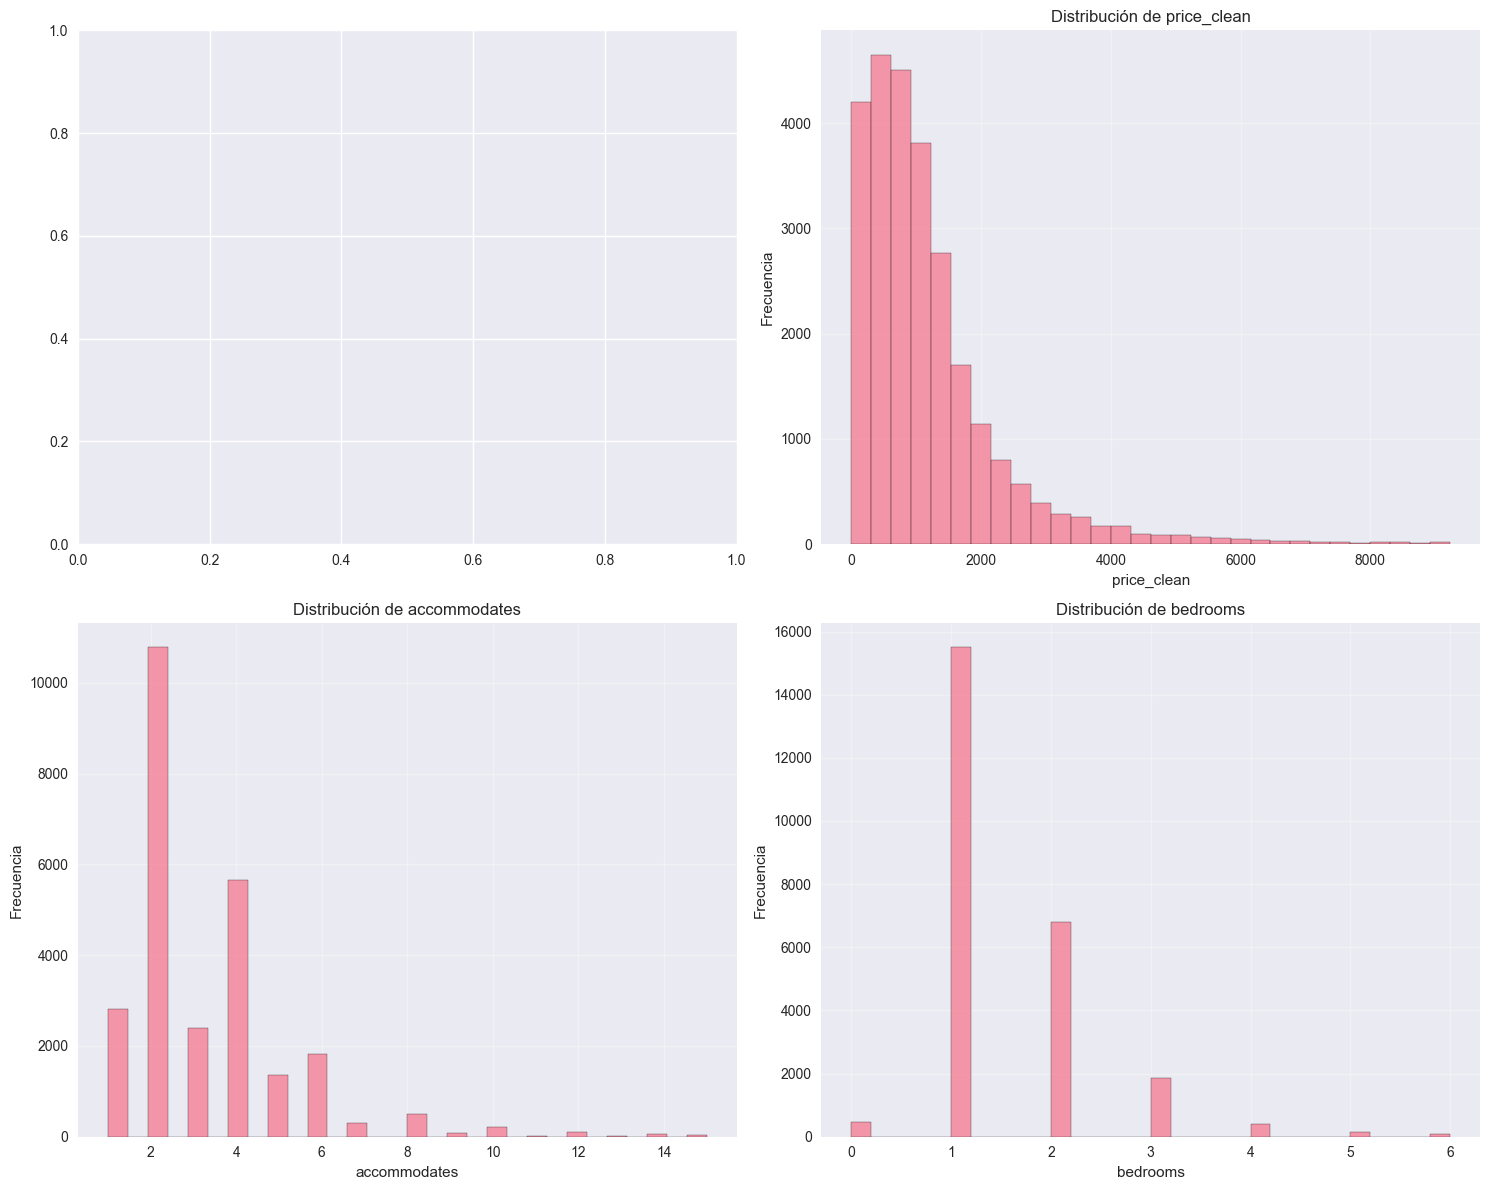


ANÁLISIS DE TIPOS DE PROPIEDAD

Top 10 tipos de propiedad:
   * Entire rental unit: 10,130 (38.4%)
   * Entire condo: 3,269 (12.4%)
   * Private room in rental unit: 3,099 (11.7%)
   * Private room in home: 2,313 (8.8%)
   * Entire loft: 1,473 (5.6%)
   * Entire home: 806 (3.1%)
   * Entire serviced apartment: 794 (3.0%)
   * Private room in condo: 783 (3.0%)
   * Room in hotel: 583 (2.2%)
   * Private room in guesthouse: 470 (1.8%)


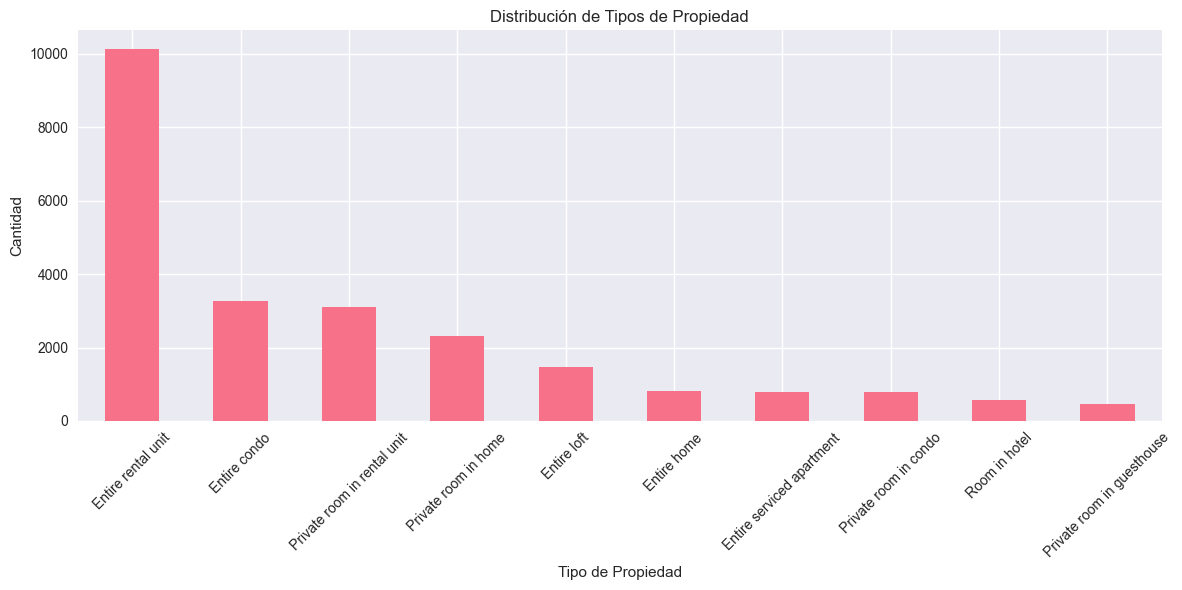


Tipos de habitación:
   * Entire home/apt: 17,235 (65.3%)
   * Private room: 8,867 (33.6%)
   * Shared room: 208 (0.8%)
   * Hotel room: 91 (0.3%)


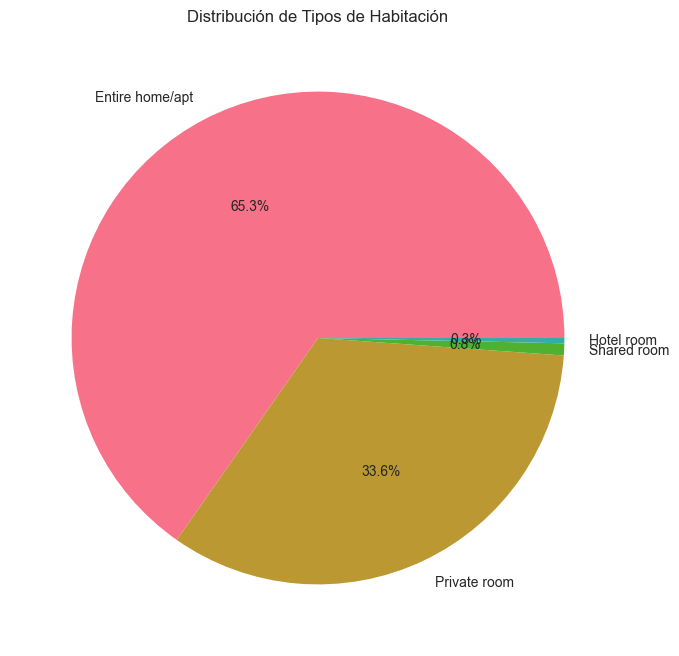


ANÁLISIS GEOGRÁFICO

Top 15 barrios con más propiedades:
   * Cuauhtémoc: 12,113 (45.9%)
   * Miguel Hidalgo: 4,486 (17.0%)
   * Benito Juárez: 3,051 (11.6%)
   * Coyoacán: 1,715 (6.5%)
   * Álvaro Obregón: 968 (3.7%)
   * Venustiano Carranza: 877 (3.3%)
   * Tlalpan: 783 (3.0%)
   * Gustavo A. Madero: 525 (2.0%)
   * Iztacalco: 447 (1.7%)
   * Cuajimalpa de Morelos: 424 (1.6%)
   * Azcapotzalco: 374 (1.4%)
   * Iztapalapa: 280 (1.1%)
   * Xochimilco: 149 (0.6%)
   * La Magdalena Contreras: 135 (0.5%)
   * Tláhuac: 44 (0.2%)


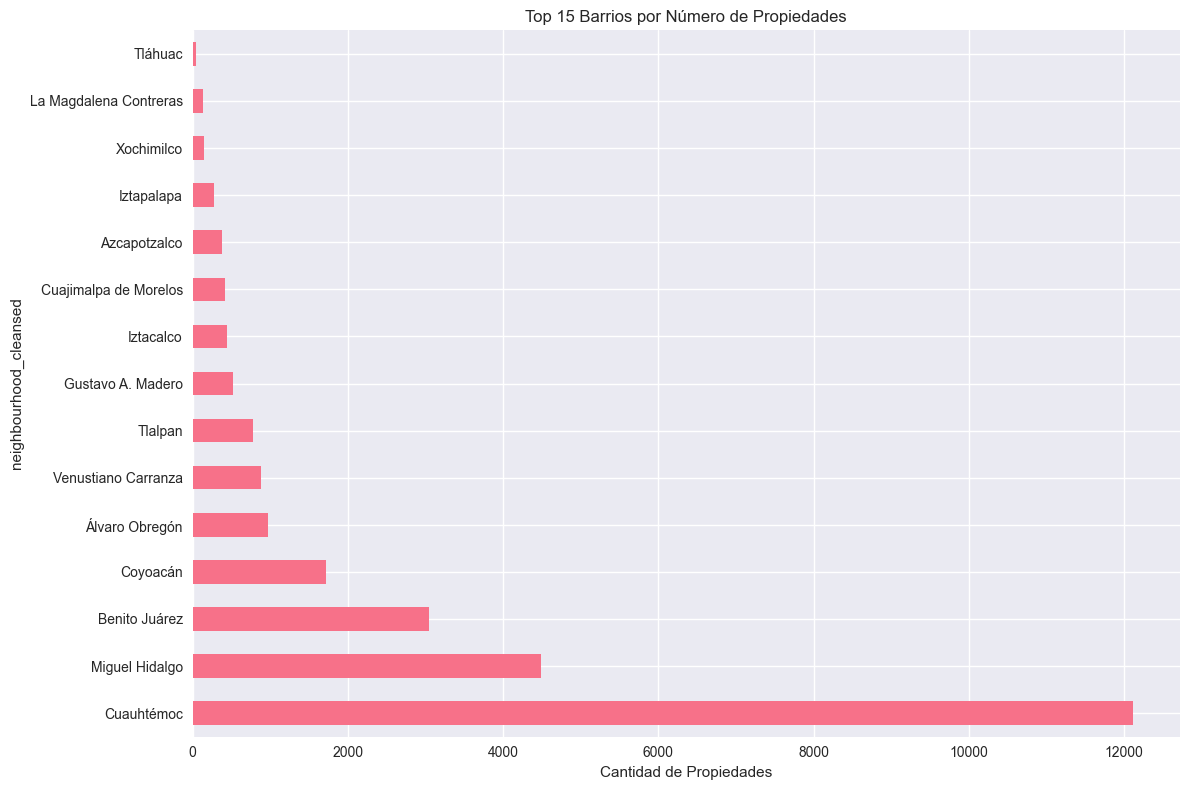


4. ANÁLISIS DE PRECIOS

ANÁLISIS DE PRECIOS

ESTADÍSTICAS DE PRECIOS:
   * Precio promedio: $1742.60
   * Precio mediano: $909.00
   * Precio mínimo: $0.00
   * Precio máximo: $900000.00
   * Desviación estándar: $17327.95

Percentiles de precios:
   * Percentil 25: $472.00
   * Percentil 50: $909.00
   * Percentil 75: $1520.00
   * Percentil 90: $2535.00
   * Percentil 95: $3682.00
   * Percentil 99: $9229.00


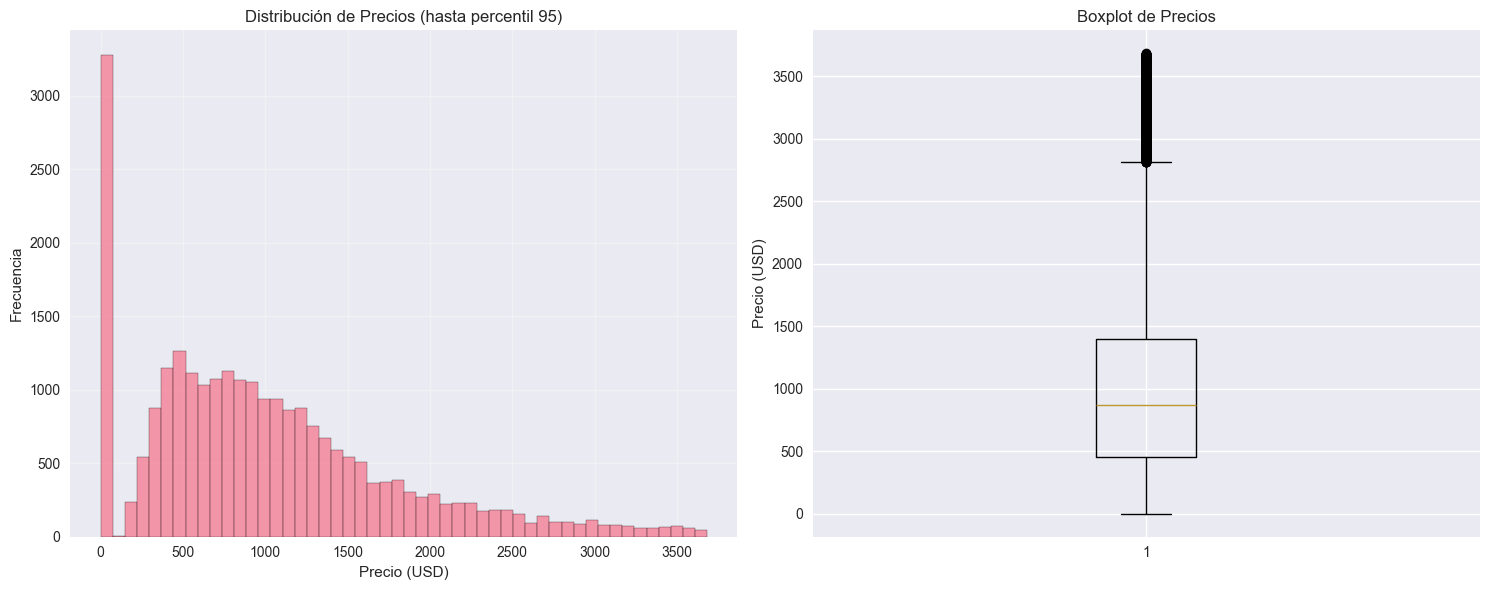


🏠 Precios promedio por tipo de habitación:
   * Entire home/apt: $1705.84 (promedio), $1195.00 (mediana), 17235.0 propiedades
   * Hotel room: $60929.81 (promedio), $890.00 (mediana), 91.0 propiedades
   * Private room: $1240.08 (promedio), $488.00 (mediana), 8867.0 propiedades
   * Shared room: $316.08 (promedio), $252.00 (mediana), 208.0 propiedades

5. ANÁLISIS DE REVIEWS

INFORMACIÓN GENERAL DE REVIEWS:
   * Total de reviews: 1,388,226
   * Reviews con fecha válida: 1,388,226
   * Rango de fechas: 2011-04-02 a 2025-07-01


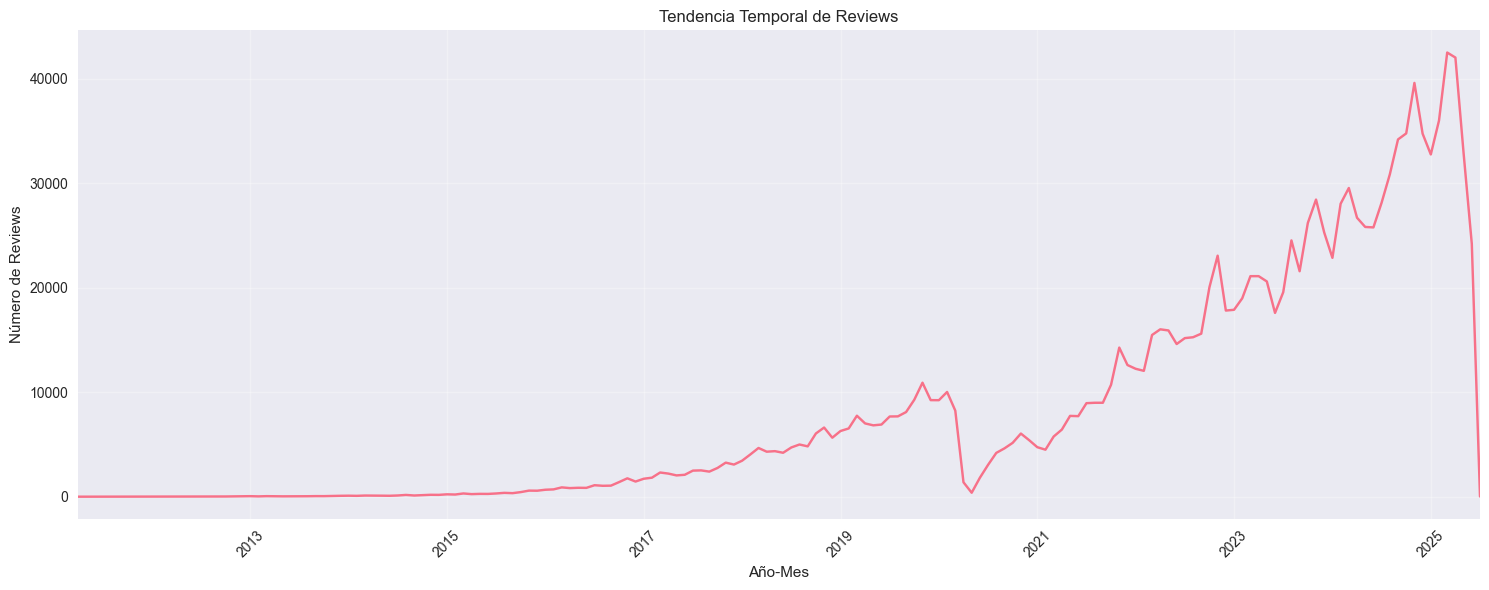


ANÁLISIS DE SENTIMIENTO:
   * Sentimiento promedio: 0.67
   * Reviews positivos: 741,617 (53.4%)
   * Reviews negativos: 7,175 (0.5%)
   * Reviews neutrales: 639,434 (46.1%)


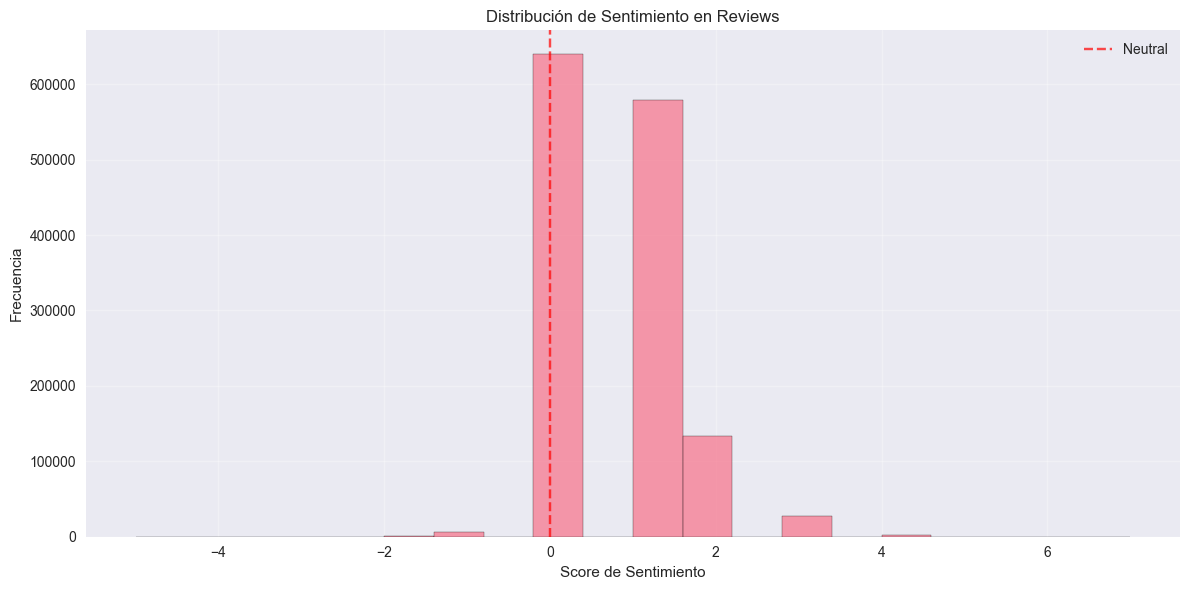


6. DETECCIÓN DE VALORES ATÍPICOS

DETECCIÓN DE OUTLIERS EN LISTINGS:
   * price_clean: 1,837 outliers (7.0%)
     Rango outliers: 3093.00 - 900000.00
   * minimum_nights: 3,466 outliers (13.1%)
     Rango outliers: 4.00 - 1125.00

7. ANÁLISIS DE CORRELACIONES

ANÁLISIS DE CORRELACIONES
Columnas numéricas para correlación: ['price_clean', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_365']


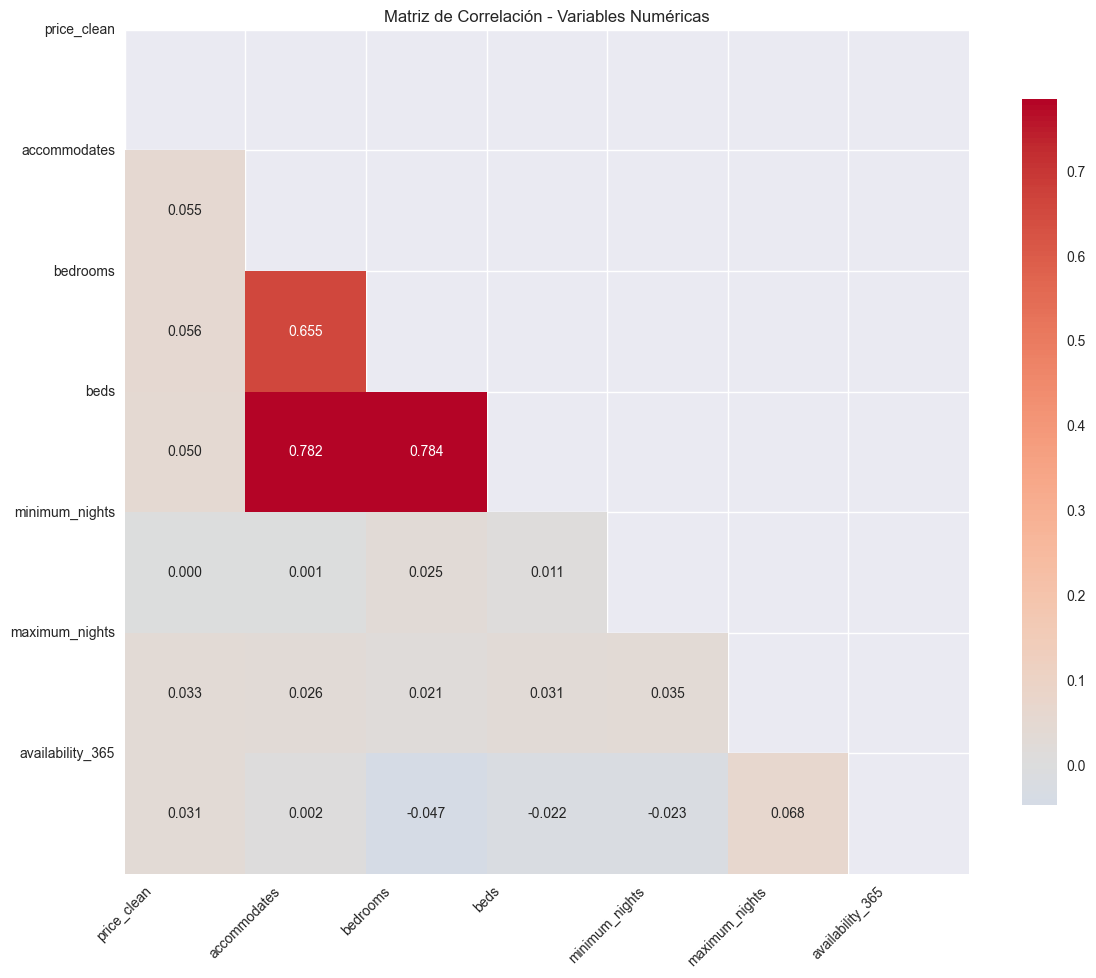


💰 Correlaciones más fuertes con el precio:

RESUMEN Y HALLAZGOS PRINCIPALES

HALLAZGOS PRINCIPALES:

CALIDAD DE DATOS:
   * listings: 26,401 registros, 13 columnas con >5% nulos
   * reviews: 1,388,226 registros, 0 columnas con >5% nulos
   * Total de registros procesados: 1,414,627

PRECIOS:
   * Precio promedio: $1742.60, mediano: $909.00

CARACTERÍSTICAS DEL MERCADO:
   * Tipo de propiedad más común: Entire rental unit
   * Tipo de habitación predominante: Entire home/apt (65.3%)

Fecha de finalización: 2025-10-15 21:08:37

ANÁLISIS EXPLORATORIO COMPLETADO

ARCHIVOS GENERADOS:
   Gráficos generados en el directorio 'output/':
   * distribuciones_numericas.png
   * tipos_propiedad.png
   * tipos_habitacion.png
   * barrios_top.png
   * analisis_precios.png
   * tendencia_reviews.png
   * sentimiento_reviews.png
   * matriz_correlacion.png

RESUMEN EJECUTIVO:
   * Datos transformados analizados exitosamente
   * Se identificaron patrones clave en precios, ubicaciones y tipos de propi

In [32]:
def main():
    os.makedirs('output', exist_ok=True)
    
    # Encabezado
    imprimir_encabezado()
    
    # 1. Cargar datos
    df_listings, df_reviews, fuente = cargar_datos()
    
    if df_listings is None and df_reviews is None:
        print("No se pudieron cargar datos. Terminando análisis.")
        return
    
    # 2. Información general
    analizar_informacion_general(df_listings, df_reviews)
    
    # 3. Análisis de calidad
    print("\n" + "=" * 80)
    print("2. ANÁLISIS DE CALIDAD DE DATOS")
    print("=" * 80)
    
    calidad_datos = {}
    datasets = {'listings': df_listings, 'reviews': df_reviews}
    for nombre, df in datasets.items():
        calidad_datos[nombre] = analizar_calidad_datos(df, nombre)
    
    # 4. Análisis específico de listings
    print("\n" + "=" * 80)
    print("3. ANÁLISIS ESPECÍFICO DE LISTINGS")
    print("=" * 80)
    
    analizar_distribuciones_numericas(df_listings)
    analizar_categorico_listings(df_listings)
    
    # 5. Análisis de precios
    print("\n" + "=" * 80)
    print("4. ANÁLISIS DE PRECIOS")
    print("=" * 80)
    
    analizar_precios(df_listings)
    
    # 6. Análisis de reviews
    print("\n" + "=" * 80)
    print("5. ANÁLISIS DE REVIEWS")
    print("=" * 80)
    
    analizar_reviews(df_reviews)
    
    # 7. Detección de outliers
    print("\n" + "=" * 80)
    print("6. DETECCIÓN DE VALORES ATÍPICOS")
    print("=" * 80)
    
    analizar_outliers(df_listings)
    
    # 8. Análisis de correlaciones
    print("\n" + "=" * 80)
    print("7. ANÁLISIS DE CORRELACIONES")
    print("=" * 80)
    
    analizar_correlaciones(df_listings)
    
    # 9. Resumen final
    generar_resumen_final(df_listings, df_reviews, fuente, calidad_datos)
    
    # Información final
    print("\n" + "=" * 80)
    print("ANÁLISIS EXPLORATORIO COMPLETADO")
    print("=" * 80)
    
    print(f"\nARCHIVOS GENERADOS:")
    output_files = [
        'distribuciones_numericas.png',
        'tipos_propiedad.png', 
        'tipos_habitacion.png',
        'barrios_top.png',
        'analisis_precios.png',
        'tendencia_reviews.png',
        'sentimiento_reviews.png',
        'matriz_correlacion.png'
    ]
    
    existing_files = [f for f in output_files if os.path.exists(f'output/{f}')]
    
    if existing_files:
        print("   Gráficos generados en el directorio 'output/':")
        for file in existing_files:
            print(f"   * {file}")
    else:
        print("   No se generaron archivos de gráficos")
    
    print(f"\nRESUMEN EJECUTIVO:")
    print(f"   * Datos {'transformados' if fuente == 'SQLite' else 'originales'} analizados exitosamente")
    print(f"   * Se identificaron patrones clave en precios, ubicaciones y tipos de propiedad") 
    print(f"   * Análisis de {len(df_listings) if df_listings is not None else 0} propiedades y {len(df_reviews) if df_reviews is not None else 0} reviews")
    print(f"   * Múltiples visualizaciones generadas para análisis de negocio")

if __name__ == "__main__":
    main()